In [1]:
%matplotlib notebook

import sys, os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pygalmesh
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

sys.path.append('..')
import mycode as code

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: dv004
--------------------------------------------------------------------------


In [2]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_mesh(vertices, facets, figsize=(6,6), **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d', aspect='equal')
    polys = Poly3DCollection(vertices[facets], **kwargs)
    ax.add_collection(polys)
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

<IPython.core.display.Javascript object>


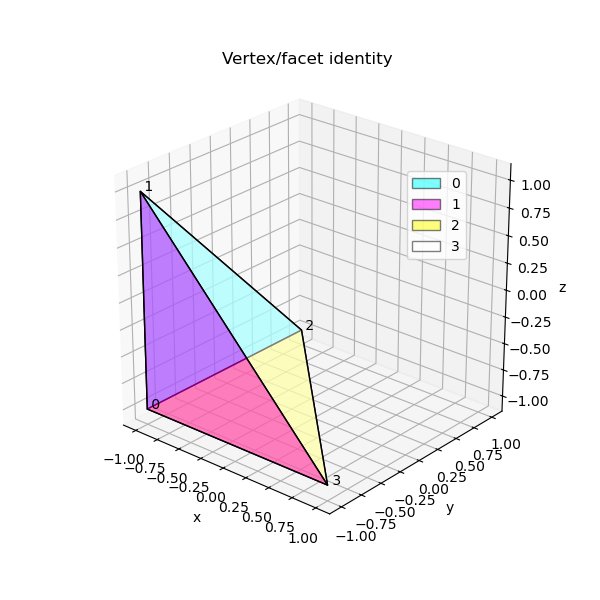

In [3]:
# create mesh of single tetrahedron

vertices = np.array([
    [-1, -1, -1], # bottem left
    [-1, -1,  1],
    [-1,  1, -1],
    [ 1, -1, -1],
])
facets = np.array([
    [0, 1, 2],
    [0, 1, 3],
    [0, 2, 3],
    [1, 2, 3]
])
tetras = np.array([
    [0, 1, 2, 3]
])
colors = [
    [0, 1, 1], # cyan
    [1, 0, 1], # magenta
    [1, 1, 0], # yellow
    [1, 1, 1]  # white
]

fig, ax = plot_mesh(vertices, facets, alpha=0.5, edgecolors='black', facecolors=colors)
ax.set_title('Vertex/facet identity')

ax.legend(handles=[
    mpl.patches.Patch(label=l, facecolor=c, edgecolor='black', linewidth=1, alpha=0.5) \
        for l, c in enumerate(colors)
], loc='upper left', bbox_to_anchor=(0.7,0.8))

for i, v in enumerate(vertices):
    ax.text(v[0], v[1], v[2], f' {i} ')

<IPython.core.display.Javascript object>


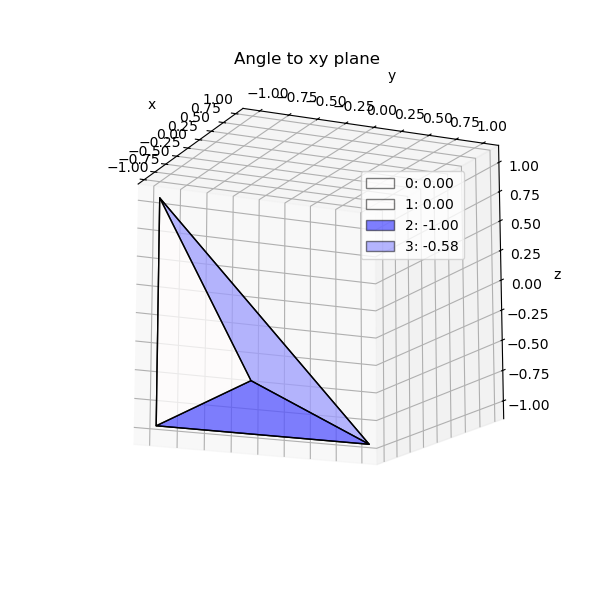

In [4]:
import matplotlib
from matplotlib.colors import ListedColormap

def compute_angles_to_xy_plane(vertices, facets):
    edges1 = vertices[facets[:,1]] - vertices[facets[:,0]]
    edges2 = vertices[facets[:,2]] - vertices[facets[:,1]]
    facet_normals = np.cross(edges1, edges2)
    norms = np.linalg.norm(facet_normals, axis=1)
    xy_normal = np.array([0, 0, 1])
    angle_cos = (facet_normals @ xy_normal) / norms
    return angle_cos

angles = compute_angles_to_xy_plane(vertices, facets)
colors = matplotlib.colormaps['seismic']((angles/2 + 1)/2)

fig, ax = plot_mesh(vertices, facets, alpha=0.5, edgecolors='black', facecolors=colors)
ax.set_title('Angle to xy plane')
ax.legend(handles=[
    mpl.patches.Patch(label=f'{l}: {a:.2f}', facecolor=c, edgecolor='black', linewidth=1, alpha=0.5) \
        for l, (a, c) in enumerate(zip(angles, colors))
], loc='upper left', bbox_to_anchor=(0.6,0.8))

<IPython.core.display.Javascript object>


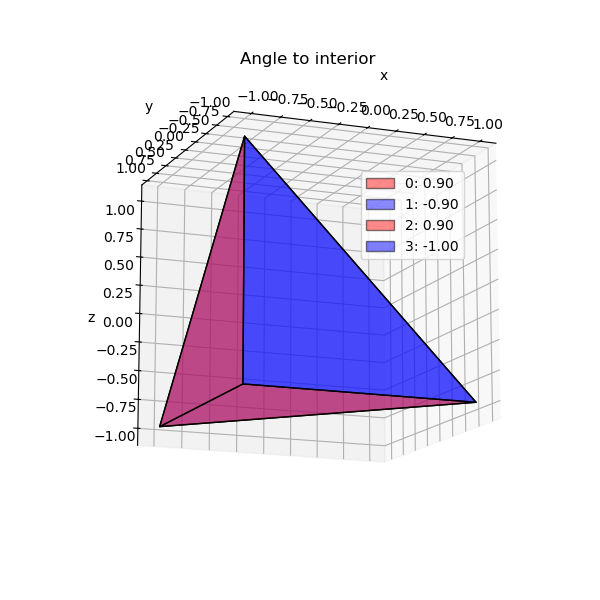

In [5]:
def compute_angles_to_interior(vertices, facets, tetras):
    edges1 = vertices[facets[:,1]] - vertices[facets[:,0]]
    edges2 = vertices[facets[:,2]] - vertices[facets[:,1]]
    facet_normals = np.cross(edges1, edges2)
    facet_norms = np.linalg.norm(facet_normals, axis=1)
    
    facet_centroids = vertices[facets].mean(axis=1)
    tetra_centroids = vertices[tetras].mean(axis=1)
    facet_tetra_dists = ((facet_centroids[:,None,:] - tetra_centroids[None,:,:])**2).sum(axis=2)
    nearest_tetras = np.argmin(facet_tetra_dists, axis=1)
    nearest_tetra_centroids = tetra_centroids[nearest_tetras]

    facet_offsets = facet_centroids - nearest_tetra_centroids
    offset_norms = np.linalg.norm(facet_offsets, axis=1)
    
    angle_cos = (facet_normals * facet_offsets).sum(axis=1) / (facet_norms * offset_norms)
    return angle_cos

angles = compute_angles_to_interior(vertices, facets, tetras)
colors = matplotlib.colormaps['seismic']((angles/2 + 1)/2)

fig, ax = plot_mesh(vertices, facets, alpha=0.5, edgecolors='black', facecolors=colors)
ax.set_title('Angle to interior')
ax.legend(handles=[
    mpl.patches.Patch(label=f'{l}: {a:.2f}', facecolor=c, edgecolor='black', linewidth=1, alpha=0.5) \
        for l, (a, c) in enumerate(zip(angles, colors))
], loc='upper left', bbox_to_anchor=(0.6,0.8))

(504, 3)
(1000, 3)
(2230, 4)


<IPython.core.display.Javascript object>


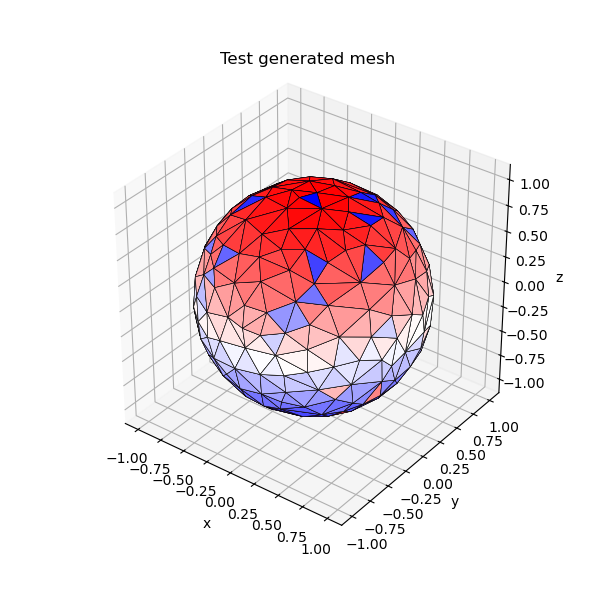

CPU times: user 156 ms, sys: 4.82 ms, total: 160 ms
Wall time: 159 ms


Text(0.5, 0.92, 'Test generated mesh')

In [7]:
%%time
# generate mesh of unit ball using pygalmesh

ball = pygalmesh.Ball([0,0,0], 1.0)
mesh = pygalmesh.generate_mesh(ball, max_cell_circumradius=0.2)

print(mesh.points.shape)
print(mesh.cells[0].data.shape)
print(mesh.cells[1].data.shape)

xy_angles = compute_angles_to_xy_plane(mesh.points, mesh.cells[0].data)

colors = matplotlib.colormaps['seismic']((xy_angles/2 + 1)/2)

fig, ax = plot_mesh(mesh.points, mesh.cells[0].data, alpha=1.0, edgecolors='black', linewidth=0.4, facecolors=colors)
ax.set_title('Test generated mesh')

<IPython.core.display.Javascript object>


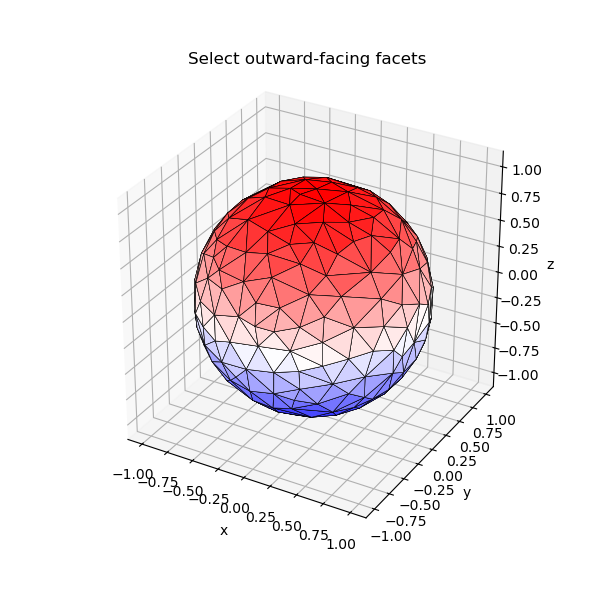

Text(0.5, 0.92, 'Select outward-facing facets')

In [8]:
xy_angles = compute_angles_to_xy_plane(mesh.points, mesh.cells[0].data)
interior_angles = compute_angles_to_interior(mesh.points, mesh.cells[0].data, mesh.cells[1].data)
facing_outward = (interior_angles > 0)
angles = np.where(facing_outward, xy_angles, -xy_angles)

colors = matplotlib.colormaps['seismic']((angles/2 + 1)/2)

fig, ax = plot_mesh(mesh.points, mesh.cells[0].data, alpha=1.0, edgecolors='black', linewidth=0.4, facecolors=colors)
ax.set_title('Select outward-facing facets')

In [9]:
ds = code.imaging.Emory4DCTDataset('../data/Emory-4DCT', case_names=['Case1Pack'])
ds.load_niftis()
ds.load_masks(roi='lung_combined_mask')

Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T00.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T10.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T20.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T30.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T40.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T50.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T60.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T70.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T80.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/NIFTI/case1_T90.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T00/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T10/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T20/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_T30/lung_combined_mask.nii.gz
Loading ../data/Emory-4DCT/Case1Pack/TotalSegment/case1_

(15212, 3)
(19832, 3)
(77670, 4)


<IPython.core.display.Javascript object>


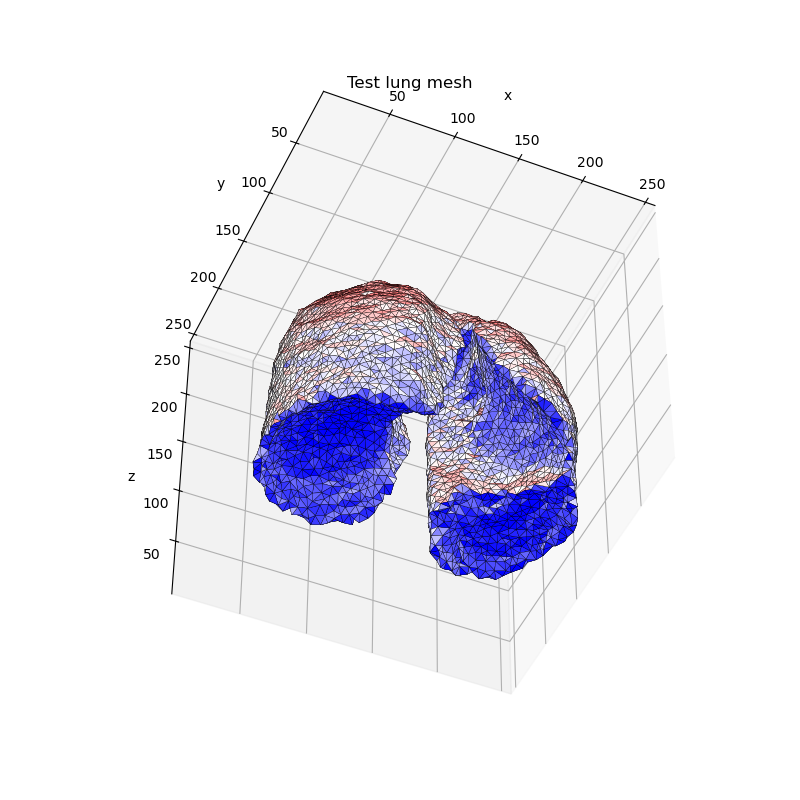

CPU times: user 39.1 s, sys: 2.09 s, total: 41.2 s
Wall time: 41.4 s


Text(0.5, 0.92, 'Test lung mesh')

In [10]:
%%time
# test generating mesh from lung segmentation mask

array = ds[0].mask.values[0].astype(np.uint16)
mesh = pygalmesh.generate_from_array(array, voxel_size=ds[0].resolution, max_cell_circumradius=5.0)

print(mesh.points.shape)
print(mesh.cells[0].data.shape)
print(mesh.cells[1].data.shape)

xy_angles = compute_angles_to_xy_plane(mesh.points, mesh.cells[0].data)
interior_angles = compute_angles_to_interior(mesh.points, mesh.cells[0].data, mesh.cells[1].data)
facing_outward = (interior_angles > 0)
angles = np.where(facing_outward, xy_angles, -xy_angles)

colors = matplotlib.colormaps['seismic']((angles/2 + 1)/2)

fig, ax = plot_mesh(
    mesh.points, mesh.cells[0].data, figsize=(8,8), alpha=1.0, edgecolors='black', linewidth=0.2, facecolors=colors
)
ax.set_title('Test lung mesh')

<IPython.core.display.Javascript object>


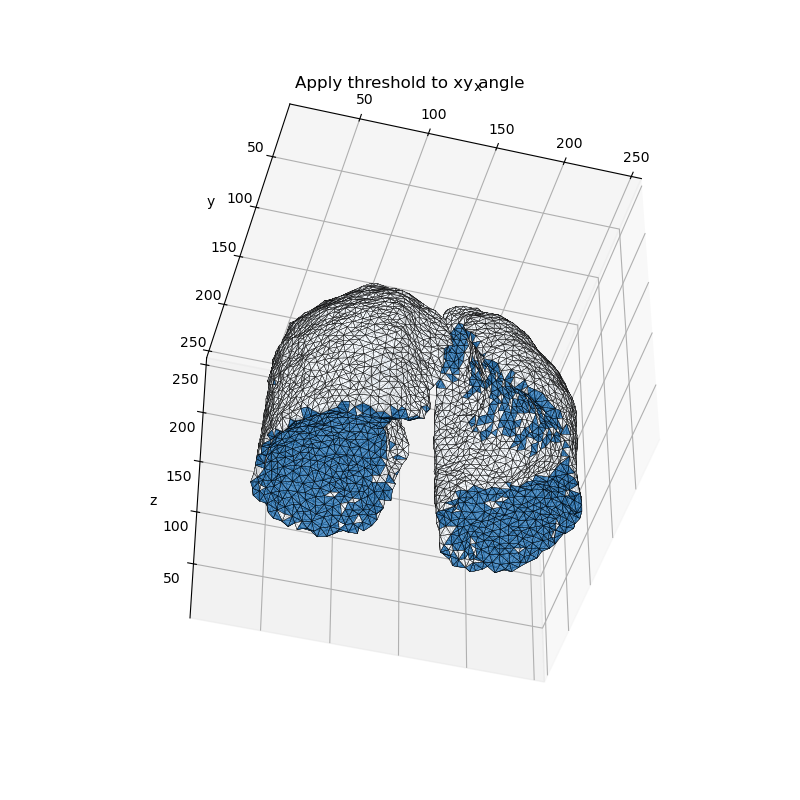

Text(0.5, 0.92, 'Apply threshold to xy angle')

In [11]:
facing_downward = (angles < -0.5)
colors = matplotlib.colormaps['Blues'](facing_downward * 0.75)

fig, ax = plot_mesh(
    mesh.points, mesh.cells[0].data, figsize=(8,8), alpha=0.5, edgecolors='black', linewidth=0.2, facecolors=colors
)
ax.set_title('Apply threshold to xy angle')

<IPython.core.display.Javascript object>


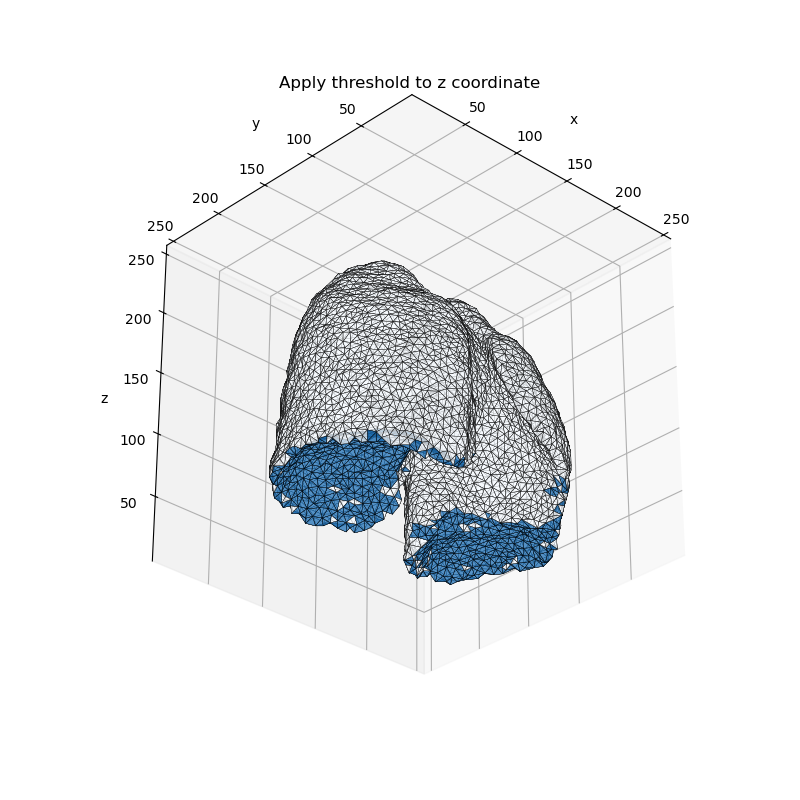

Text(0.5, 0.92, 'Apply threshold to z coordinate')

In [12]:
z = mesh.points[mesh.cells[0].data].mean(axis=1)[:,2]

lower_portion = (z - z.min()) / (z.max() - z.min()) < 0.23
colors = matplotlib.colormaps['Blues']((facing_downward & lower_portion) * 0.75)

fig, ax = plot_mesh(
    mesh.points, mesh.cells[0].data, figsize=(8,8), alpha=0.5, edgecolors='black', linewidth=0.2, facecolors=colors
)
ax.set_title('Apply threshold to z coordinate')

<IPython.core.display.Javascript object>


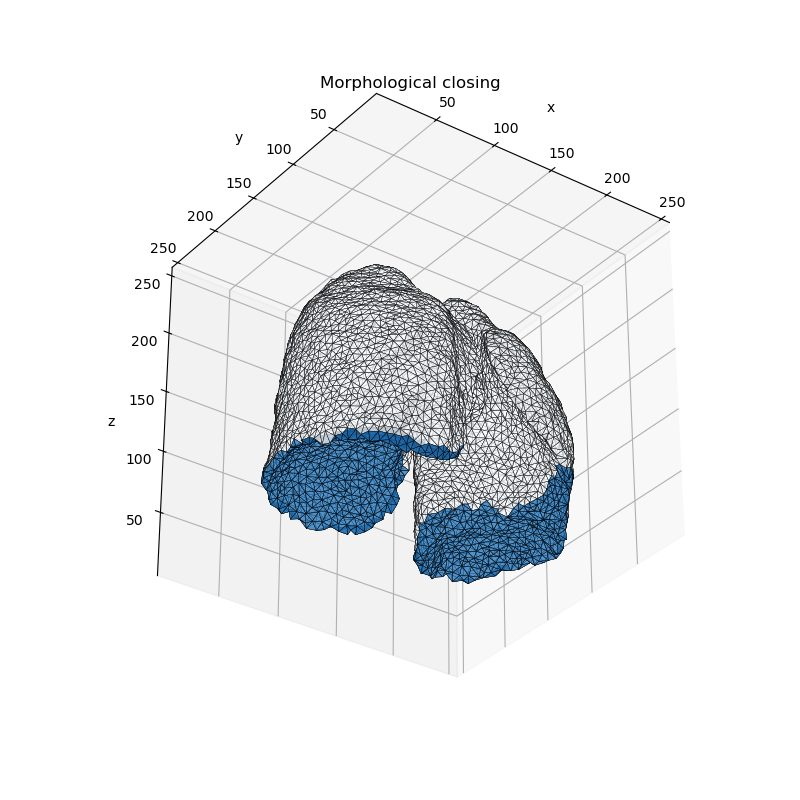

Text(0.5, 0.92, 'Morphological closing')

In [13]:
from collections import defaultdict
from itertools import permutations

def smooth_facet_values(vertices, facets, facet_values, func, order=1):
    '''
    Args:
        vertices: (N, 3) array of 3D vertex coordinates
        facets: (M, 3) array of indices of triangle vertices
        facet_values: (M, D) array of values assigned to facets
        func: Reduces sets of facet values to a single value
        order: Order of structure elements to define neighborhoods
            For order=1, use common vertices
            For order=2, use common edges
    Returns:
        new_facet_values: (M, D) array of values from applying
            func to each facet's local neighborhood of values
    '''
    # mapping from elements to facets that share that element
    common_elements = defaultdict(set)
    for i, facet_vertices in enumerate(facets):
        for element in permutations(facet_vertices, order):
            common_elements[element].add(i)

    # unordered sets of vertices for each facet
    vertex_sets = [set(v) for v in facets]
   
    new_facet_values = np.zeros_like(facet_values)
    for i, facet_vertices in enumerate(facets):
        neighbor_values = []
        for element in permutations(facet_vertices, order):
            for j in common_elements[element]:
                if vertex_sets[j] != vertex_sets[i]:
                    neighbor_values.append(facet_values[j])
        new_facet_values[i] = func(neighbor_values)
            
    return new_facet_values

indicator = (facing_downward & lower_portion).astype(float)

radius = 5
for i in range(radius):
    indicator = smooth_facet_values(mesh.points, mesh.cells[0].data, indicator, np.max)
for i in range(radius):
    indicator = smooth_facet_values(mesh.points, mesh.cells[0].data, indicator, np.min)

colors = matplotlib.colormaps['Blues'](indicator * 0.75)

fig, ax = plot_mesh(
    mesh.points, mesh.cells[0].data, figsize=(8,8), alpha=0.5, edgecolors='black', linewidth=0.2, facecolors=colors
)
ax.set_title('Morphological closing')

<IPython.core.display.Javascript object>


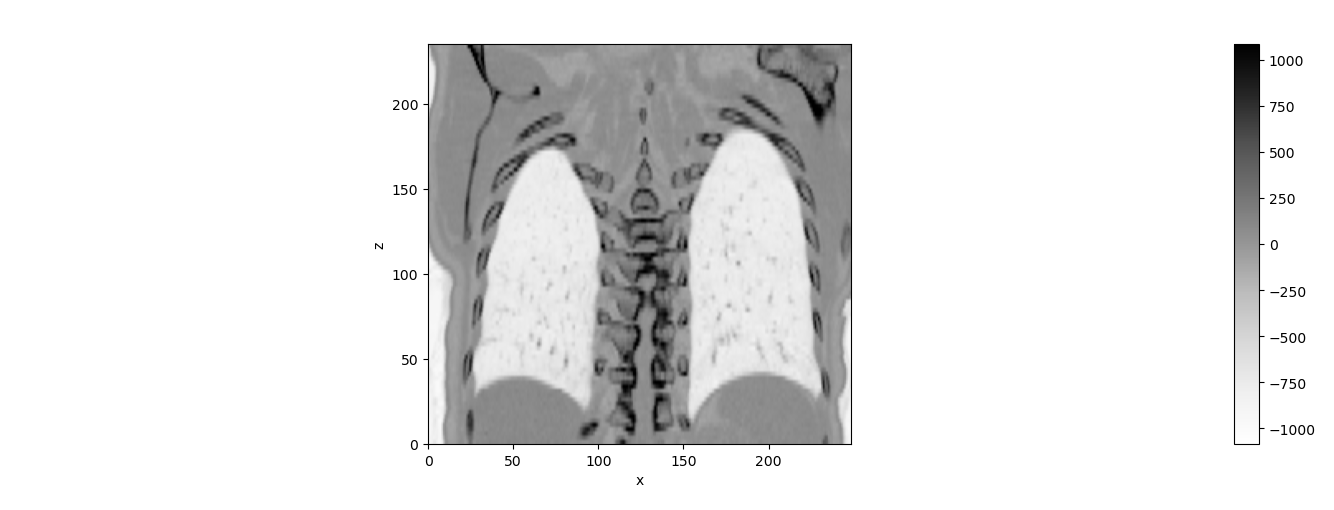

interactive(children=(SelectionSlider(description='phase', options=((0, 0), (10, 1), (20, 2), (30, 3), (40, 4)…

In [17]:
code.visual.XArrayViewer(ds[0].array, x='x', y='z', cmap='Greys')